# Load Data

**Data**

 - Tair (min and max) at 28 locations, from 2000 to 2020 (CSV file)
 - LST (TDA and TNA) at 28 locations, from 2002 to 2020 (CSV file)
 - NDVI at 28 locations, from 2000 to 2020 (CSV file)

In [1]:
import array
from datetime import date, timedelta
import datetime
import re

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from progressbar import ProgressBar
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from vam.whittaker import *

Functions

In [2]:
def fromstring(x):
    
    '''Converts string to datetime object'''
    
    try:
        d = datetime.datetime.strptime(x, '%d/%m/%Y').date()
    except:
        d = datetime.datetime.strptime(x, '%Y-%m-%d').date()
        
    return d

def fromdekad(x):

    # seeking for date pattern in the filename
    dek = re.search(r'\d{4}\d{2}D\d{1}', x).group()

    # getting year, month and dekad
    year = int(dek[0:4])
    month = int(dek[4:6])
    d = dek[6:8]
    
    if d=="D1":
        greg_date = date(year,month,10)
    elif d=="D2":
        greg_date = date(year,month,20)
    else:
        greg_date = date(year,month,28)
        
    return greg_date

def smoothing(ts, nodata):

    wts =  np.array((ts!=nodata)*1,dtype='double')
    
    lag_correlation = lag1corr(np.array(ts[0:len(ts)-1]), np.array(ts[1:]), nodata)
    
    if lag_correlation > 0.5:
        sr = np.arange(-2, 1.2, 0.2).round(2)
    elif lag_correlation <= 0.5:
        sr = np.arange(0, 3.2, 0.2).round(2)
    else:
        sr = np.arange(-1, 1.2, 0.2).round(2)

    ts_smoothed, b = ws2doptvp(y=ts, w=wts, llas=array.array('d',sr), p=0.9)
    
    return(ts_smoothed)

def ts_time(location, T, LST):
    
    df = pd.DataFrame(np.nan, index=T.index, columns = ['T', 'LST'])
    df['T'] = T[location]
    df['LST'] = LST[location]
    df = df.dropna()

    return df

def spatial_serie(time_step, T, LST):
    
    df = pd.DataFrame(np.nan, index=T.columns.values, columns = ['T', 'LST'])
    df['T'] = T.loc[time_step].values
    df['LST'] = LST.loc[time_step].values

    return df

def dffits(X,Y):
    
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    ols = OLSInfluence(results).dffits[0]
    
    return ols

**Tair**

In [3]:
##########
#  Tmax  #
##########
Tmax = pd.read_csv(
    'Data/tmax.csv', 
    header = 1,
    skiprows = [2, 3])

Tmax['Dekad'] = Tmax['Dekad'].apply(fromdekad)
Tmax = Tmax.rename(columns={'Dekad': "Date"})
Tmax = Tmax.set_index('Date')
Tmax = Tmax.replace(-999.0, np.nan)

##########
#  Tmin  #
##########
Tmin = pd.read_csv(
    'Data/tmin.csv', 
    header = 1,
    skiprows = [2, 3])

Tmin['Dekad'] = Tmin['Dekad'].apply(fromdekad)
Tmin = Tmin.rename(columns={'Dekad': "Date"})
Tmin = Tmin.set_index('Date')
Tmin = Tmin.replace(-999.0, np.nan)


#getting rid of columns with no data
Tmin = Tmin.drop(columns=['Inhambane','Quelimane'])
Tmax = Tmax.drop(columns=['Inhambane','Quelimane'])

**LST**

In [4]:
LST = pd.read_csv(
    'Data/MYD_LST.csv', 
    index_col=0, 
    usecols = ['ID', 
               'Date', 
               'MYD11A1_006_LST_Day_1km',
              'MYD11A1_006_LST_Night_1km'])


#renaming the columns
LST = LST.rename(columns={'MYD11A1_006_LST_Day_1km': "TDA", 'MYD11A1_006_LST_Night_1km': "TNA"})


# Convert string Date to datetime.date
LST['Date'] = LST['Date'].apply(fromstring)

#Smoothing
TDA = []
TNA = []

locs = list(set(LST.index.values))
locs.sort()
for l in locs:
    for x in smoothing(LST.loc[l]['TDA'].values, 0):
        TDA.append(x) 
    for x in smoothing(LST.loc[l]['TNA'].values, 0):
        TNA.append(x)  
    
LST['TDA'] = TDA
LST['TNA'] = TNA

In [5]:
#reordering and converting to dekadal

locs = list(set(LST.index.values))
locs.sort()

#########
#  TNA  #
#########
TNA = pd.DataFrame(np.nan, index=Tmin.index, columns = locs)

pbar = ProgressBar()
for l in pbar(locs):
    lst = []
    for i,d in enumerate(Tmin.index.values):
        if (d in LST.loc[l]['Date'].values):
            lst.append(LST.loc[l][LST.loc[l]['Date'] == d]['TNA'].values[0])
        else:
            lst.append(np.nan)
        lst = [np.nan if x==0 else x for x in lst] 
    TNA[l] = lst
    
    
    
#########
#  TDA  #
#########
TDA = pd.DataFrame(np.nan, index=Tmax.index, columns = locs)

pbar = ProgressBar()
for l in pbar(locs):
    lst = []
    for i,d in enumerate(Tmax.index.values):
        if (d in LST.loc[l]['Date'].values):
            lst.append(LST.loc[l][LST.loc[l]['Date'] == d]['TDA'].values[0])
        else:
            lst.append(np.nan)
        lst = [np.nan if x==0 else x for x in lst] 
    TDA[l] = lst

    
#getting ride of locations with no data
TNA = TNA.drop(columns=['Inhambane','Quelimane'])
TDA = TDA.drop(columns=['Inhambane','Quelimane'])

100% |########################################################################|
100% |########################################################################|


**NDVI**

In [6]:
###########
#   MOD   #
###########
MOD_NDVI = pd.read_csv(
    'Data/MOD_NDVI.csv', 
    index_col=0, 
    usecols = ['ID', 
               'Date', 
               'MOD13A2_006__1_km_16_days_NDVI'])


#renaming the columns
MOD_NDVI = MOD_NDVI.rename(columns={'MOD13A2_006__1_km_16_days_NDVI': "ndvi"})


# Convert string Date to datetime.date
MOD_NDVI['Date'] = MOD_NDVI['Date'].apply(fromstring)


###########
#   MYD   #
###########
MYD_NDVI = pd.read_csv(
    'Data/MYD_NDVI.csv', 
    index_col=0, 
    usecols = ['ID', 
               'Date', 
               'MYD13A2_006__1_km_16_days_NDVI'])


#renaming the columns
MYD_NDVI = MYD_NDVI.rename(columns={'MYD13A2_006__1_km_16_days_NDVI': "ndvi"})


# Convert string Date to datetime.date
MYD_NDVI['Date'] = MYD_NDVI['Date'].apply(fromstring)



###########
#   MXD   #
###########
#Concatenating MOD and MYD

NDVI = pd.DataFrame(columns = ['Date', 'ndvi'])

locs = list(set(MOD_NDVI.index.values))
locs.sort()
for l in locs:
    
    #concatenating MOD and MYD
    MOD = MOD_NDVI.loc[l]
    MYD = MYD_NDVI.loc[l]
    MXD = pd.concat([MOD,MYD])
    
    #sorting by date
    MXD = MXD.set_index('Date')
    MXD.index = pd.to_datetime(MXD.index)
    MXD = MXD.sort_index() 
    
    #adding location name
    MXD['ID'] = [l] * len(MXD)
    MXD = MXD.reset_index()
    MXD = MXD.set_index('ID')
    
    #concatenating all locations
    NDVI = pd.concat([NDVI, MXD])

In [7]:
#Smoothing
ndvi = []

locs = list(set(NDVI.index.values))
locs.sort()
for l in locs:
    for x in smoothing(NDVI.loc[l]['ndvi'].values, -3000):
        ndvi.append(x)   
    
NDVI['ndvi'] = ndvi


#removing nodata
NDVI[NDVI['ndvi'] == -3000] = np.nan
NDVI = NDVI.dropna()

In [8]:
#reordering and keeping dekadal
NDVI_dek = pd.DataFrame(np.nan, index=Tmin.index, columns = locs)

pbar = ProgressBar()
for l in pbar(locs):
    ndvi = []    
    NDVI_loc = NDVI.loc[l]
    NDVI_loc = NDVI_loc.set_index('Date')
    NDVI_loc.index = pd.to_datetime(NDVI_loc.index)
    NDVI_loc = NDVI_loc.resample('D').interpolate() 
    
    for i,d in enumerate(Tmin.index.values):
        if (d in NDVI_loc.index):
            ndvi.append(NDVI_loc.loc[d].ndvi)
        else:
            ndvi.append(np.nan)
            
    NDVI_dek[l] = ndvi
    
NDVI = NDVI_dek 

#getting rid of columns with no data
NDVI = NDVI.drop(columns=['Inhambane','Quelimane'])

100% |########################################################################|


&nbsp;

**Getting rid of abnormal points**

There can be 2 types of influantial points: **outliers** and points with **high leverage**. 

If an observation has a response value that is very different from the predicted value based on a model, then that observation is called an **outlier** (unusual y values). On the other hand, if an observation has a particularly unusual combination of predictor values, then that observation is said to have **high leverage** (extreme x values).

We want to detect both outliers and high leverage points. To do so we use the DFFITS parameter defined as:

$DFFITS = \frac{\hat{y_i} - \hat{y_{(i)}}}{\sqrt{MSE_{(i)}h_ii}}$

The numerator measures the difference in the predicted responses obtained when the $i^{th}$ data point is included and excluded from the analysis. The denominator is the estimated standard deviation of the difference in the predicted responses. Therefore, the $DFFITS$ quantifies the number of standard deviations that the fitted value changes when the $i^{th}$ data point is omitted.

An observation is influential if the absolute value of its $DFFITS$ value is greater than:

$2 \sqrt{\frac{k + 2}{n - k - 2}}$

where $n$ =  number of observations and $k$ = the number of predictor terms = $1$

**We remove the influential points over the temporal regression and spatial regression**.

In [9]:
TNA_clean = TNA.copy()
TDA_clean = TDA.copy()
Tmin_clean = Tmin.copy()
Tmax_clean = Tmax.copy()

locs = TNA.columns.values

#######
# TNA #
#######

#Across locations
for l in locs:

    #extract ts
    df = ts_time(l, Tmin_clean, TNA_clean)
    X = df['LST'].values.reshape(-1, 1)
    Y = df['T'].values.reshape(-1, 1)
    ols = dffits(X,Y)    

    #get date of abnormal points
    df['ols'] = ols
    ols_threshold = 2*np.sqrt(3/(len(df)-3))
    remove_dates = df[df['ols']>ols_threshold].index.values
    
    #remove points from both T and LST dataframes
    for d in remove_dates:
        TNA_clean.loc[d][l] = np.nan
        Tmin_clean.loc[d][l] = np.nan

        
#Across time
for d in TNA_clean.index.values:

    #extract ts
    df = spatial_serie(d, Tmin_clean, TNA_clean)
    df = df.dropna()
    if (len(df)>2):
        X = df['LST'].values.reshape(-1, 1)
        Y = df['T'].values.reshape(-1, 1)
        ols = dffits(X,Y)    

        #get date of abnormal points
        df['ols'] = ols
        ols_threshold = 2*np.sqrt(3/(len(df)-3))
        remove_locs = df[df['ols']>ols_threshold].index.values

        #remove points from both T and LST dataframes
        for l in remove_locs:
            TNA_clean.loc[d][l] = np.nan
            Tmin_clean.loc[d][l] = np.nan

#######
# TDA #
#######

#Across locations
for l in locs:
    
    #extract ts
    df = ts_time(l, Tmax_clean, TDA_clean)
    X = df['LST'].values.reshape(-1, 1)
    Y = df['T'].values.reshape(-1, 1)
    ols = dffits(X,Y)        
    
    #get date of abnormal points
    df['ols'] = ols
    ols_threshold = 2*np.sqrt(3/(len(df)-3))
    remove_dates = df[df['ols']>ols_threshold].index.values
    
    #remove points from both T and LST dataframes
    for d in remove_dates:
        TDA_clean.loc[d][l] = np.nan
        Tmax_clean.loc[d][l] = np.nan
        
        
#Across time
for d in TDA_clean.index.values:

    #extract ts
    df = spatial_serie(d, Tmax_clean, TDA_clean) 
    df = df.dropna()
    if (len(df)>2):
        X = df['LST'].values.reshape(-1, 1)
        Y = df['T'].values.reshape(-1, 1)
        ols = dffits(X,Y)    

        #get date of abnormal points
        df['ols'] = ols
        ols_threshold = 2*np.sqrt(3/(len(df)-3))
        remove_locs = df[df['ols']>ols_threshold].index.values

        #remove points from both T and LST dataframes
        for l in remove_locs:
            TDA_clean.loc[d][l] = np.nan
            Tmax_clean.loc[d][l] = np.nan

In [10]:
#location widget
location_widget = widgets.Dropdown(
    options=locs,
    value='BeiraAero',
    description='Select loc:')

location_widget

Dropdown(description='Select loc:', index=1, options=('Angoche', 'BeiraAero', 'Changalane', 'Chimoio', 'Chokwe…

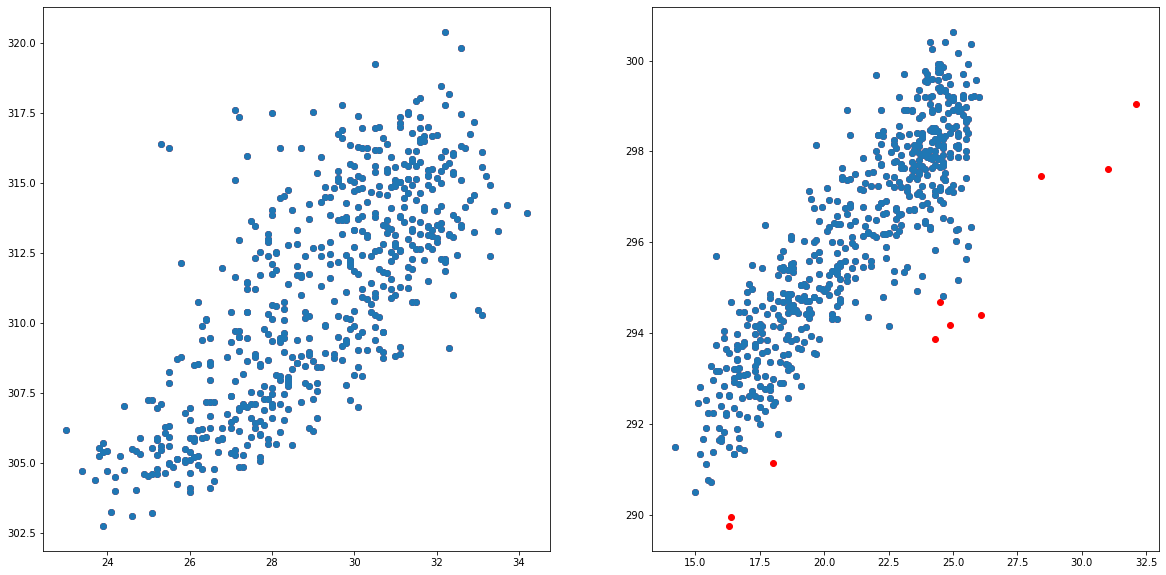

In [11]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))

axs[0].scatter(Tmax[location_widget.value], TDA[location_widget.value], color = 'r');
axs[0].scatter(Tmax_clean[location_widget.value], TDA_clean[location_widget.value]);

axs[1].scatter(Tmin[location_widget.value], TNA[location_widget.value], color = 'r');
axs[1].scatter(Tmin_clean[location_widget.value], TNA_clean[location_widget.value]);

This is only the visualization of time series (no spatial series), so some points which do not seem like outliers might be red (because they are outliers in the spatial series)

### Saving data

In [12]:
TNA_clean.to_csv('Data/dataframes/TNA.csv')
TDA_clean.to_csv('Data/dataframes/TDA.csv')

Tmin_clean.to_csv('Data/dataframes/Tmin.csv')
Tmax_clean.to_csv('Data/dataframes/Tmax.csv')

NDVI.to_csv('Data/dataframes/NDVI.csv')